In [1]:
from google.colab import files
import pandas as pd
import io

# Upload Excel file
uploaded = files.upload()

for filename in uploaded.keys():
    df = pd.read_excel(io.BytesIO(uploaded[filename]), sheet_name='RAW')

# Show first few rows
df.head()


Saving x8tS03qMQo-Ndww2EsPeeQ_3cc295b7326d4a77a7d5a7c3c5f3b1a1_1910_m2_assign_dataset_v1.0.xlsx to x8tS03qMQo-Ndww2EsPeeQ_3cc295b7326d4a77a7d5a7c3c5f3b1a1_1910_m2_assign_dataset_v1.0.xlsx


,OrderDate,UserId,Gender,ProductId,ProductGroup,City,CityTier,PinCode,Zone,Revenue,Units,Cancelled_Units
0,2017-11-01,User1,0,2,Tshirts_Men,"Bangalore, India",Metro,560095,SOUTH,999.0,1,1
1,2017-11-01,User2,0,3,Tshirts_Men,"Bangalore, India",Metro,560076,SOUTH,539.0,1,0
2,2017-11-01,User2,1,4,Tshirts_Men,"Bangalore, India",Metro,560076,SOUTH,499.0,1,0
3,2017-11-01,User2,1,5,Tshirts_Men,"Bangalore, India",Metro,560076,SOUTH,1012.0,1,0
4,2017-11-01,User3,0,6,Tshirts_Men,"Kolkata, India",Metro,700107,EAST,849.0,1,0


In [2]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

df.dropna(subset=['Revenue', 'Units'], inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83374 entries, 0 to 83373
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   OrderDate        83374 non-null  datetime64[ns]
 1   UserId           83374 non-null  object        
 2   Gender           83374 non-null  int64         
 3   ProductId        83374 non-null  int64         
 4   ProductGroup     83374 non-null  object        
 5   City             83374 non-null  object        
 6   CityTier         83371 non-null  object        
 7   PinCode          83374 non-null  int64         
 8   Zone             83345 non-null  object        
 9   Revenue          83374 non-null  float64       
 10  Units            83374 non-null  int64         
 11  Cancelled_Units  83374 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 7.6+ MB


In [3]:
import sqlite3

conn = sqlite3.connect("orders.db")

df.to_sql('orders', conn, if_exists='replace', index=False)


83374

In [4]:
queries = {
    "Total Stats": """
        SELECT
            SUM(Revenue) AS TotalRevenue,
            SUM(Units) AS TotalUnits,
            SUM(Cancelled_Units) AS TotalCancelled
        FROM orders;
    """,

    "Top Cities by Revenue": """
        SELECT City, SUM(Revenue) AS Revenue
        FROM orders
        GROUP BY City
        ORDER BY Revenue DESC
        LIMIT 5;
    """,

    "Monthly Revenue Trend": """
        SELECT strftime('%Y-%m', OrderDate) AS Month, SUM(Revenue) AS MonthlyRevenue
        FROM orders
        GROUP BY Month
        ORDER BY Month;
    """,

    "Cancellation Rate by Zone": """
        SELECT Zone,
               SUM(Cancelled_Units) AS Cancelled,
               SUM(Units) AS TotalUnits,
               ROUND(SUM(Cancelled_Units)*1.0 / SUM(Units), 3) AS CancelRate
        FROM orders
        GROUP BY Zone
        ORDER BY CancelRate DESC;
    """,

    "Gender-wise Product Preference": """
        SELECT Gender, ProductGroup, SUM(Units) AS TotalUnits
        FROM orders
        GROUP BY Gender, ProductGroup
        ORDER BY Gender, TotalUnits DESC;
    """
}

results = {title: pd.read_sql_query(sql, conn) for title, sql in queries.items()}

results['Total Stats']


,TotalRevenue,TotalUnits,TotalCancelled
0,5.451323e+07,84760,24432


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


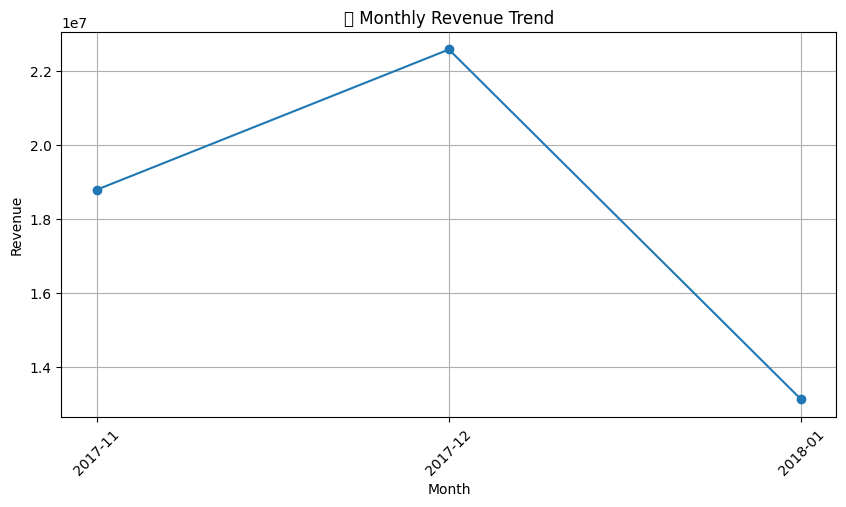

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(results["Monthly Revenue Trend"]['Month'], results["Monthly Revenue Trend"]['MonthlyRevenue'], marker='o')
plt.title("📈 Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


/tmp/ipython-input-6-3738969034.py:7: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


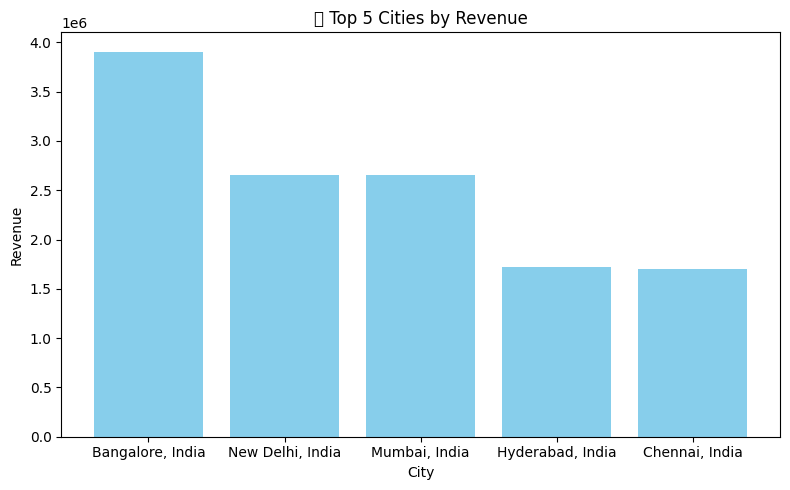

In [6]:
# Top Cities by Revenue
plt.figure(figsize=(8,5))
plt.bar(results["Top Cities by Revenue"]['City'], results["Top Cities by Revenue"]['Revenue'], color='skyblue')
plt.title("🏙 Top 5 Cities by Revenue")
plt.xlabel("City")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()


/tmp/ipython-input-7-2784562544.py:9: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


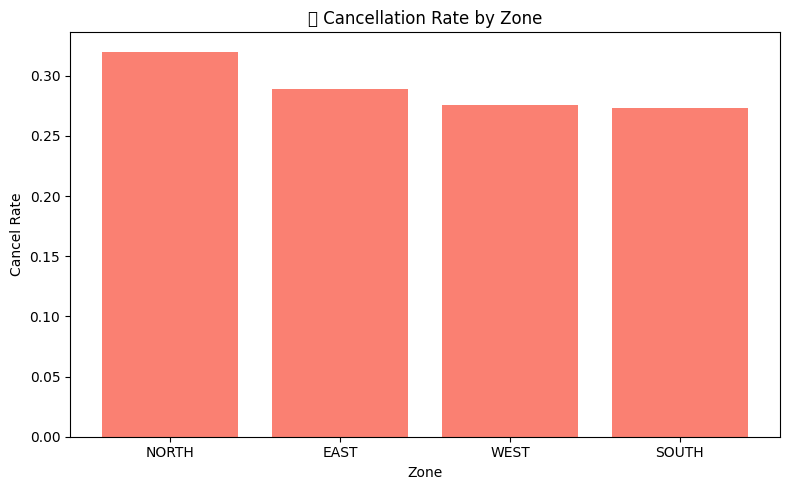

In [7]:
# Cancellation Rate by Zone
cancel_clean = results["Cancellation Rate by Zone"].dropna(subset=['Zone'])

plt.figure(figsize=(8,5))
plt.bar(cancel_clean['Zone'], cancel_clean['CancelRate'], color='salmon')
plt.title("❌ Cancellation Rate by Zone")
plt.xlabel("Zone")
plt.ylabel("Cancel Rate")
plt.tight_layout()
plt.show()
